# DMFT self-energy: CTQMC solver + analytic continuation vs NRG solver

In this tutorial, we will compare two single site dynamical mean field results for the Hubbard model on the Bethe lattice of infinite connectivity: one is the analytic continuation of a Matsubara frequency self-energy computed using a continuous-time quantum Monte Carlo hybridization expansion impurity solver ([CTHYB]), and the other is the retarded self-energy obtained directly with a numerical renormalization group (NRG) impurity solver. The results used here are for $U=4D$, where $D$ is the bandwidth, at 20% doping and temperature T=0.05D, and are taken from Ref. [\[1\]][DMFT_res] (see Fig.3).

\[1\] [Xiaoyu Deng, Jernej Mravlje, Rok Žitko, Michel Ferrero, Gabriel Kotliar, and Antoine Georges
Phys. Rev. Lett. 110:086401, 2013][DMFT_res]

[DMFT_res]: https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.110.086401
[CTHYB]: https://triqs.github.io/cthyb/master/


In [ ]:
import OmegaMaxEnt_TRIQS as OT
from pytriqs.gf import *
import numpy as np
from pytriqs.plot.mpl_interface import oplot,plt  #to plot the result
import os
import shutil as su

Let us first create a working directory to group the output files:

In [2]:
output_dir = "output_MaxEnt"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
os.chdir(output_dir)

Now, we set the temperature and load the Matsubara frequency self-energy:

In [3]:
beta = 20
S_data = np.loadtxt("../CTHYB/Sigma_20.0_fittail.dat")

Then, we create a scalar *GfImFreq* object S and set *S.data* equal to the data we just loaded. By default, the mesh in a *GfImFreq* object contains both positive and negative frequencies, but the data we just loaded contains only positive frequencies. We can use the property $G(-i\omega_n)=\left[G(i\omega_n)\right]^*$ to fill the whole frequency mesh:

In [4]:
N = S_data.shape[0]
S = GfImFreq(target_shape=(), n_points=N, beta=beta, name="$S_{CTHYB}$",)
S.data.real = np.concatenate((np.flipud(S_data[:,1]), S_data[:,1]))
S.data.imag = np.concatenate((-np.flipud(S_data[:,2]), S_data[:,2]))

If we plot the result using oplot we get:

In [5]:
%matplotlib notebook

<IPython.core.display.Javascript object>


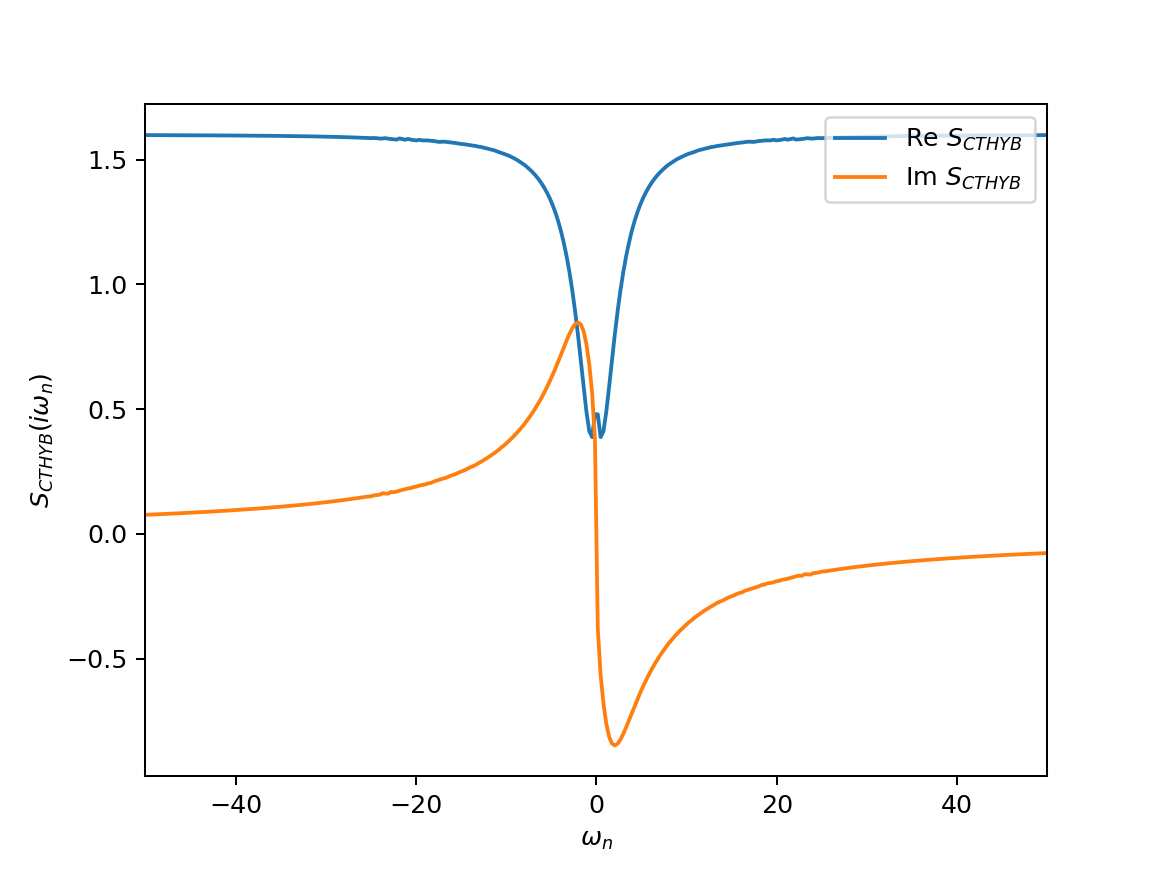

(-50, 50)

In [6]:
plt.figure(1)
oplot(S)
plt.xlim(-50,50)

Note: with *%matplotlib notebook*, you have to turn off the interactive mode of the figure before any other figures can be displayed.

Now, because the real part of S contains a constant, i.e. the Hartree-Fock term, we have to set *G_inf_finite=True* in the call to *compute_GfReFreq()*. We will also tell $\Omega MaxEnt$ to compute the Padé result and set the imaginary part of the frequency for Padé with the parameter *eta_Pade*:

In [7]:
eta = 1e-5
SR = OT.compute_GfReFreq(S, G_inf_finite=True, compute_Pade=True, eta_Pade=eta, interactive_mode=False, name="$S_{CT+ME}$")

continuation done


If the output of the previous line is `continuation done` we can continue by loading the NRG result and the Padé result that was saved in file *Pade_Green_function.dat*:

In [8]:
S_nrg = np.loadtxt("../NRG/imsigma-beta20.dat")
S_pade_data = np.loadtxt("Pade_Green_function.dat")
S_pade = GfReFreq(target_shape=(), window = (S_pade_data[0,0], S_pade_data[-1,0]), n_points=S_pade_data.shape[0], name="$S_{CT+Pade}$")
S_pade.data.real = S_pade_data[:,1]
S_pade.data.imag = S_pade_data[:,2]

and compare the imaginary parts of the retarded self-energies:

<IPython.core.display.Javascript object>


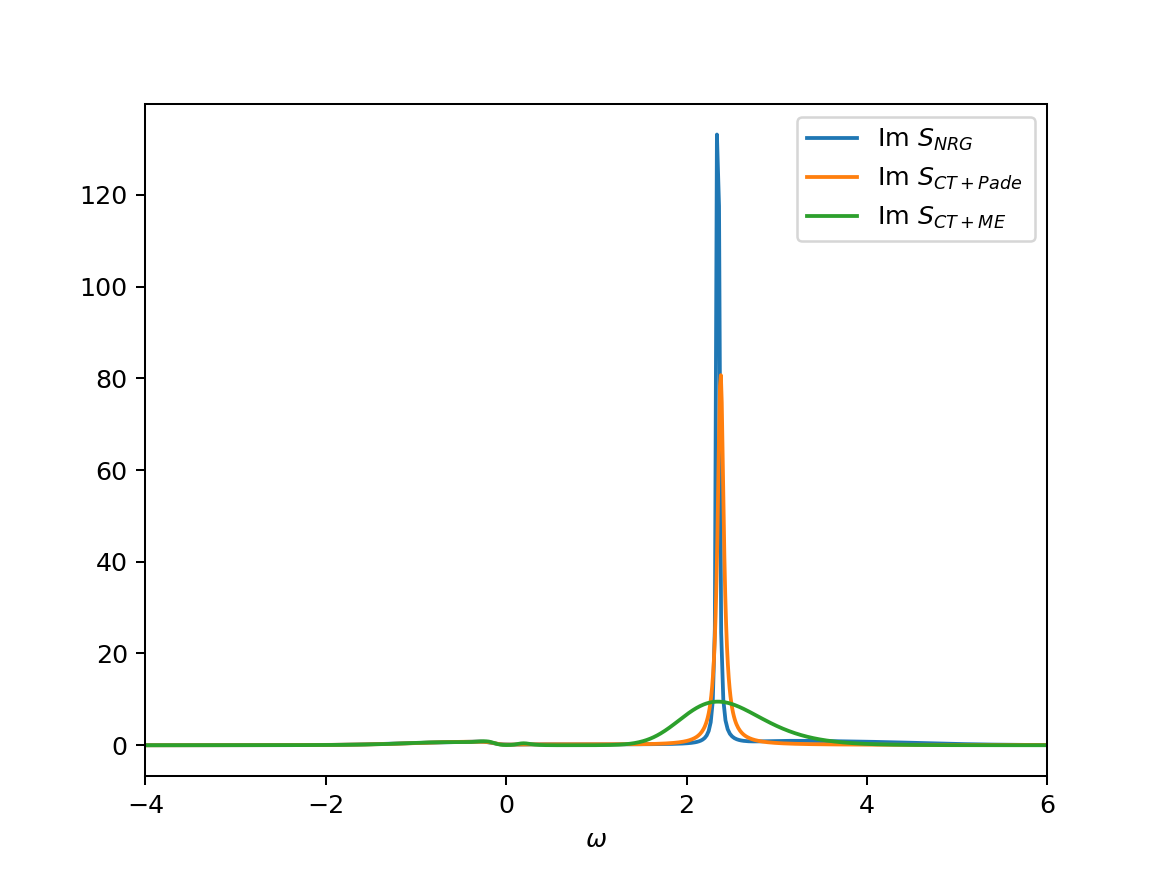

<IPython.core.display.Javascript object>


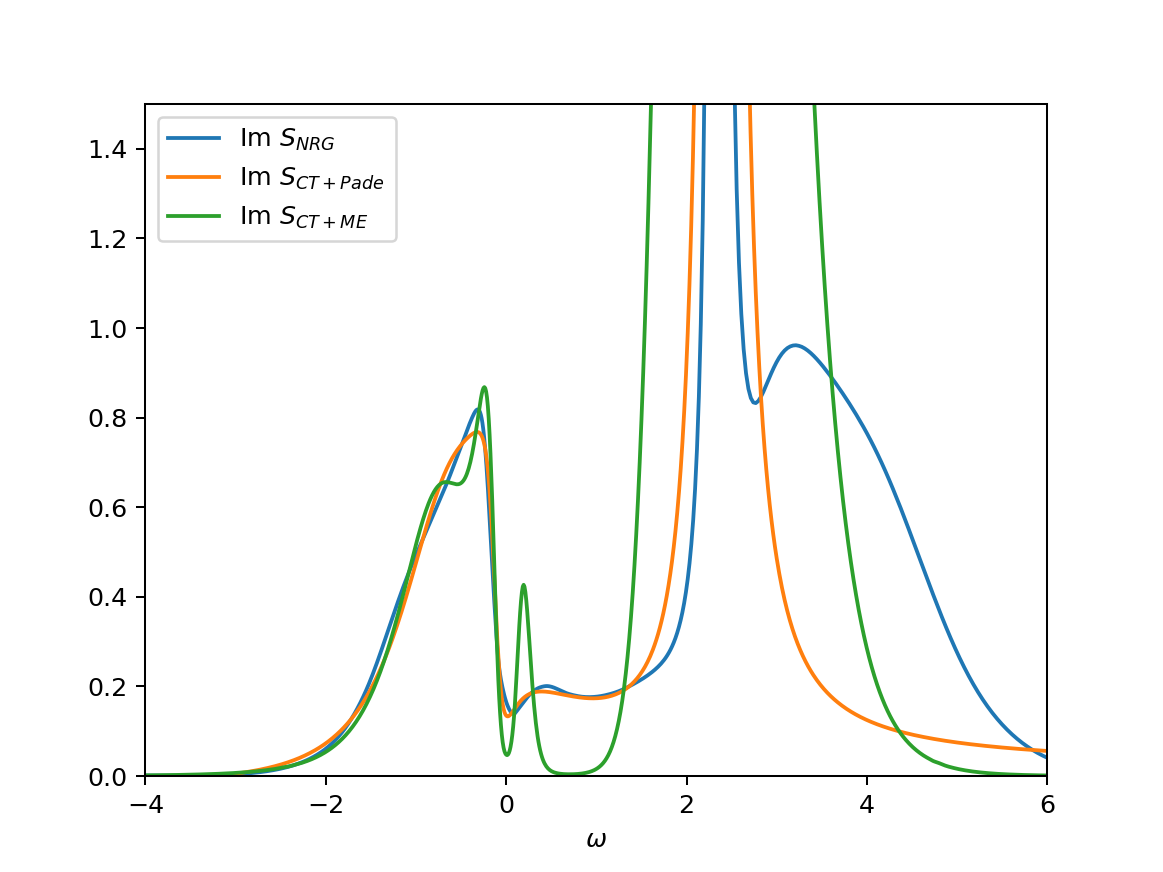

In [9]:
plt.figure(2)
plt.plot(S_nrg[:,0], -S_nrg[:,1], label='Im $S_{NRG}$')
oplot(-S_pade.imag)
oplot(-SR.imag)
plt.ylabel('')
plt.xlim([-4,6])
plt.legend()
plt.figure(3)
plt.plot(S_nrg[:,0], -S_nrg[:,1], label='Im $S_{NRG}$')
oplot(-S_pade.imag)
oplot(-SR.imag)
plt.ylabel('')
plt.xlim([-4,6])
plt.ylim([0,1.5])
plt.legend()

Here we see that the CTHYB+MaxEnt and NRG results are qualitatively similar, but in CTHYB+MaxEnt the large peak at $\omega=2.5$ is much broader, while the low frequency part is sharper. The Padé result is closer to NRG, although it is also missing the peak around $\omega=3.5$.

There is another way to analytically continue the self-energy. It is to perform the analytic continuation on an artificial Green's function:

$$G(i\omega)=\frac{1}{i\omega_n - \Sigma(i\omega_n)}$$
and then use
$$\Sigma^R(\omega)=\omega-\frac{1}{G^R(\omega)}\,.$$

We first define the artificial Green's function:

In [ ]:
G = GfImFreq(target_shape=(), beta=20, n_points=N, name="$G_{CTHYB}$",)
G << inverse(iOmega_n-S)

and let us see what it looks like:

<IPython.core.display.Javascript object>


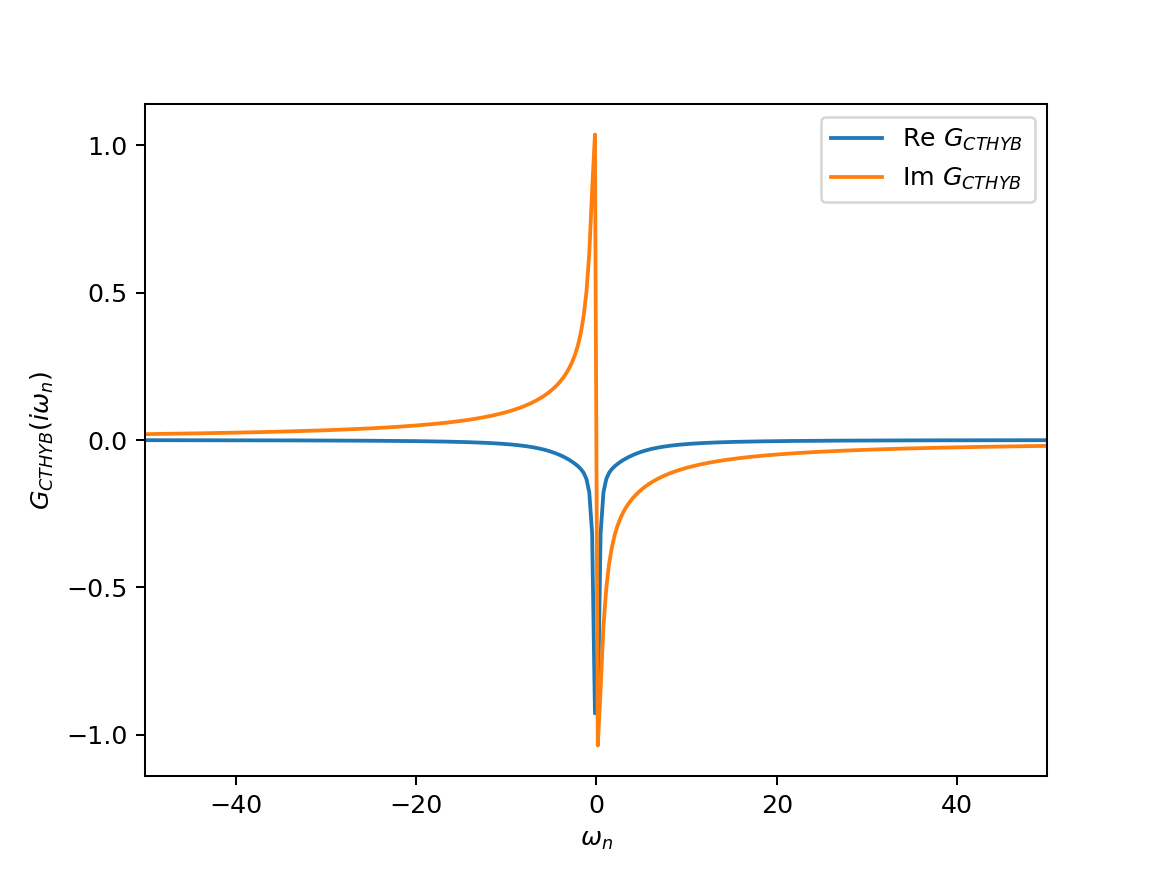

(-50, 50)

In [11]:
plt.figure(4)
oplot(G)
plt.xlim(-50,50)

Now we can call *compute_GfReFreq()*:

In [ ]:
GR = OT.compute_GfReFreq(G, compute_Pade=True, eta_Pade=1e-5, interactive_mode=False, name="$G_{CT+ME}$")

Here, it is possible that the continuation failed because the default frequency grid is not well suited to the spectrum. If so, the last message printed by $\Omega MaxEnt$ in the terminal where this notebook is running should be: `optimal spectrum has not been found. The real frequency grid might not be adapted to the spectrum`.

In any case, let us redo the analytic continuation with a more adapted frequency grid. The simplest way to improve the grid is to set parameters *freq_step* and *spectrum_width*. To determine how to set those values, we can look, on one hand, at the values printed in the terminal as `frequency step at the grid origin:` and `boundaries of main spectral range:`, and, on the other hand, look at the last spectrum computed, i.e. the spectrum at the lowest $\alpha$, which can be displayed with *display_figures()* (among other output figures):

In [13]:
%matplotlib inline

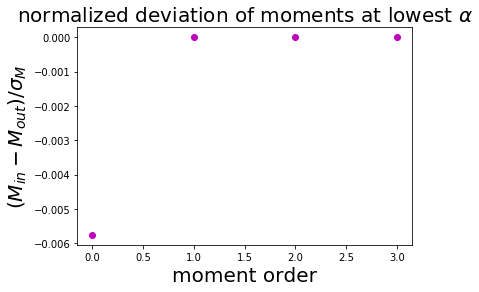

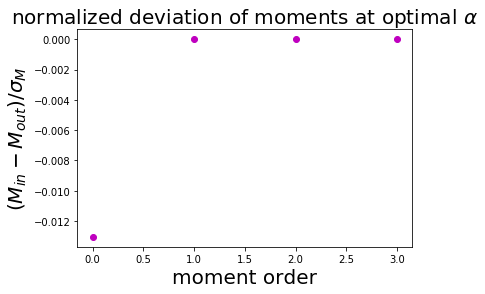

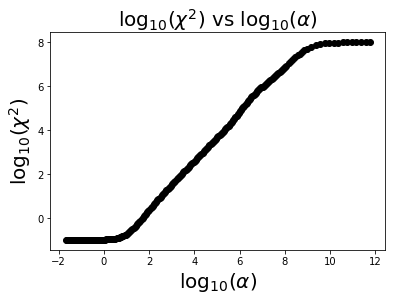

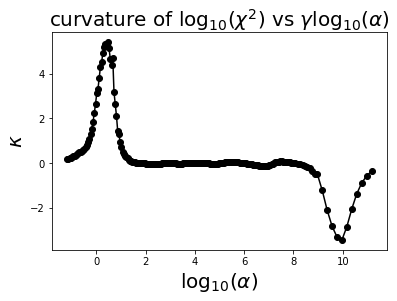

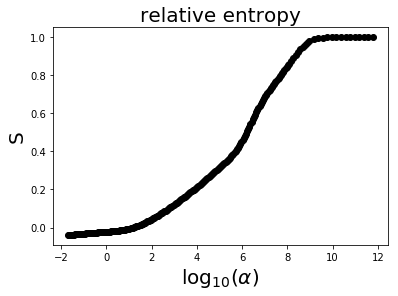

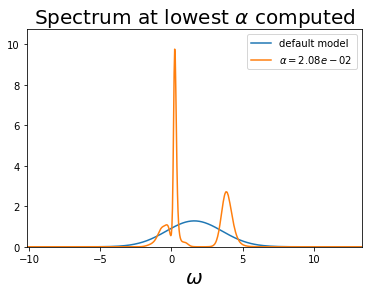

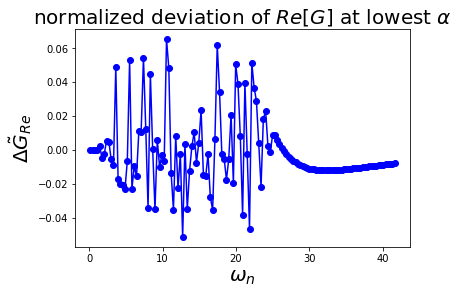

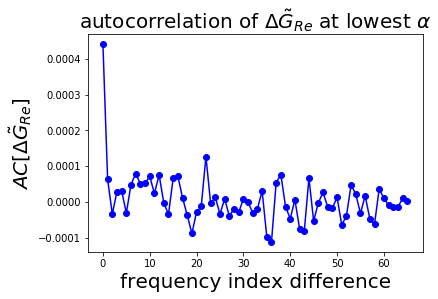

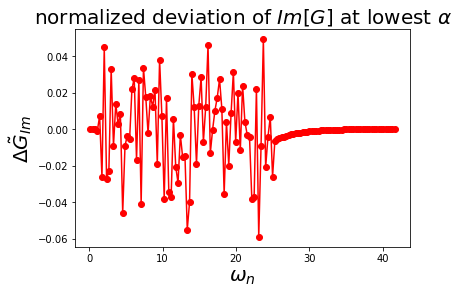

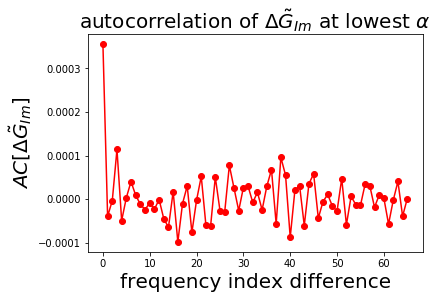

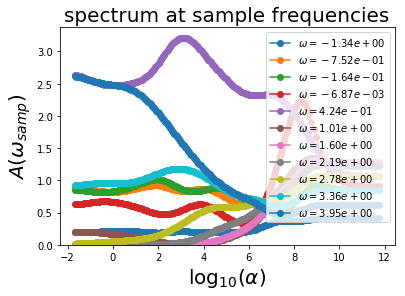

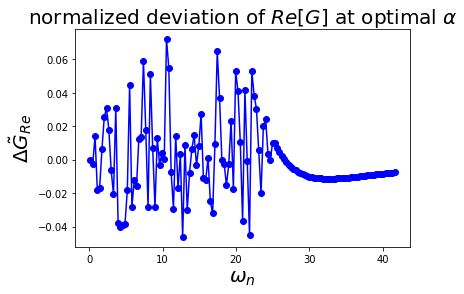

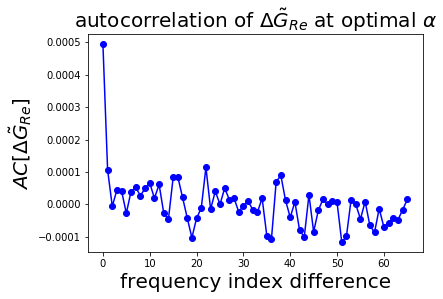

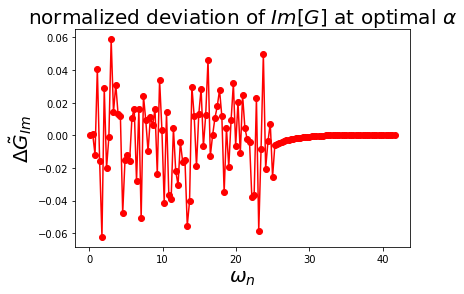

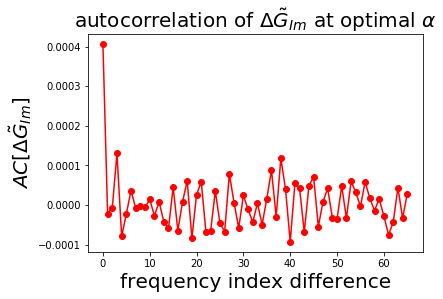

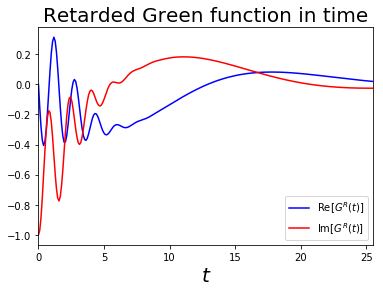

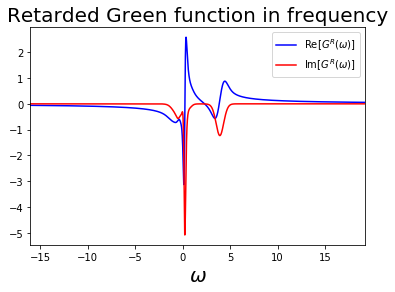

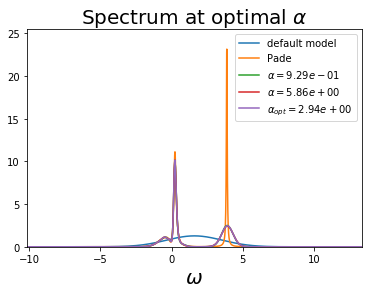

In [14]:
OT.display_figures()

From the terminal, we know that the frequency step and the spectrum width used in the previous calculation are 0.039 and 5.88, respectively. From the figure titled *Spectrum at lowest $\alpha$ computed*, we can see that the width of the spectrum is about 7. We can also reduce sligtly the step to 0.02. We then call *compute_GfReFreq()* again with

In [ ]:
GR = OT.compute_GfReFreq(G, freq_step=0.02, 
         spectrum_width=7.0, 
         compute_Pade=True, 
         eta_Pade=eta, 
         interactive_mode=False, 
         displ_alpha_min_figs=False, 
         name="$G_{CT+ME}$")

Now, the calculation should be successful and you should see the message `continuation done` as the output of the previous cell. If we execute again the command *OT.display_figures()* in the cell above, we should see that the curve $\log\chi^2$ vs $\log\alpha$ shows the three MaxEnt regimes: *default model*, *information fitting* and *noise fitting*. The last figure is showing the optimal spectrum. Now let us obtain the self-energy corresponding to the Padé and MaxEnt Green's functions:

In [ ]:
G_pade_data = np.loadtxt("Pade_Green_function.dat")
G_pade = GfReFreq(target_shape=(), window=(G_pade_data[0,0], G_pade_data[-1,0]), n_points=G_pade_data.shape[0])
G_pade.data.real = G_pade_data[:,1]
G_pade.data.imag = G_pade_data[:,2]
SG_pade = GfReFreq(target_shape=(), window=(G_pade_data[0,0], G_pade_data[-1,0]), n_points=G_pade_data.shape[0], name="$S_{G,CT+Pade}$")
SG_pade << Omega-inverse(G_pade)
SG = GfReFreq(target_shape=(), window=(GR.mesh.omega_min, GR.mesh.omega_max), n_points=len(GR.mesh), name="$S_{G,CT+ME}$")
SG << Omega-inverse(GR)

Finally, we diplay all the results

In [17]:
%matplotlib notebook

<IPython.core.display.Javascript object>


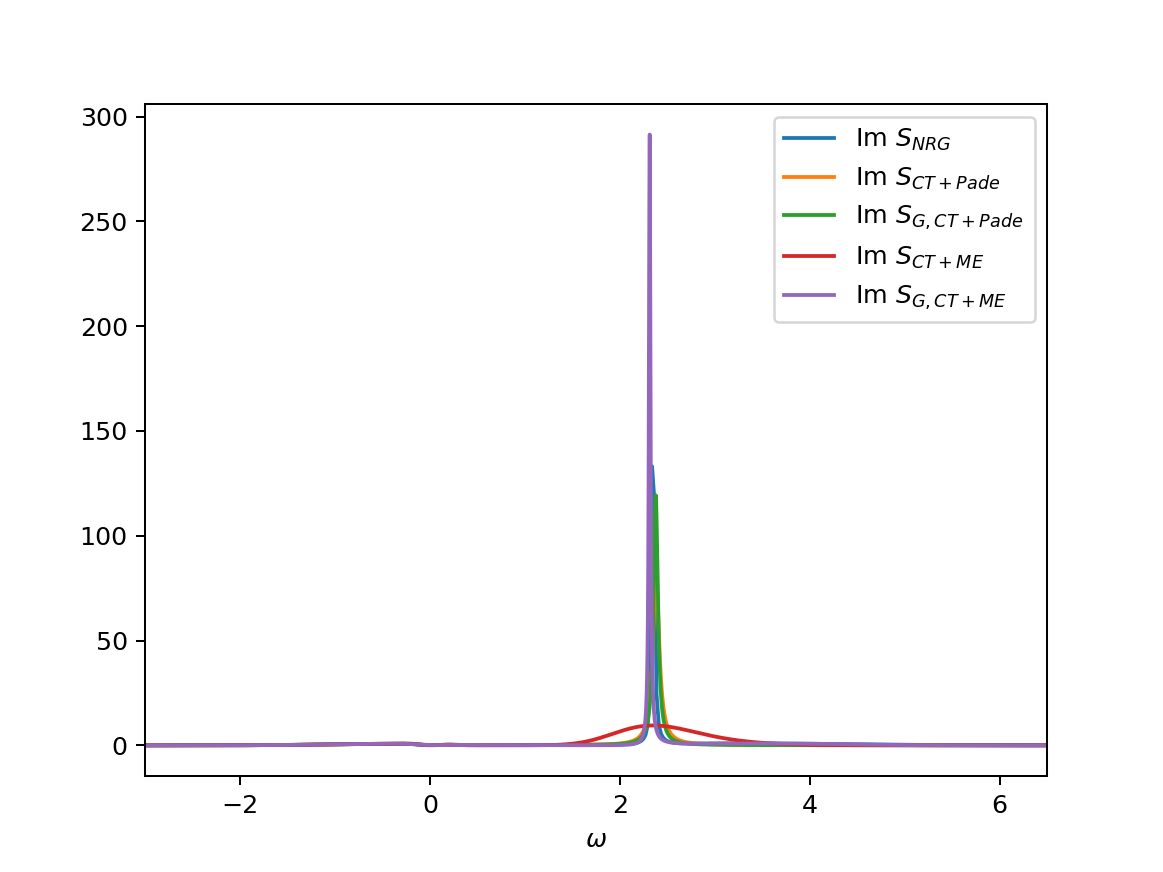

<IPython.core.display.Javascript object>


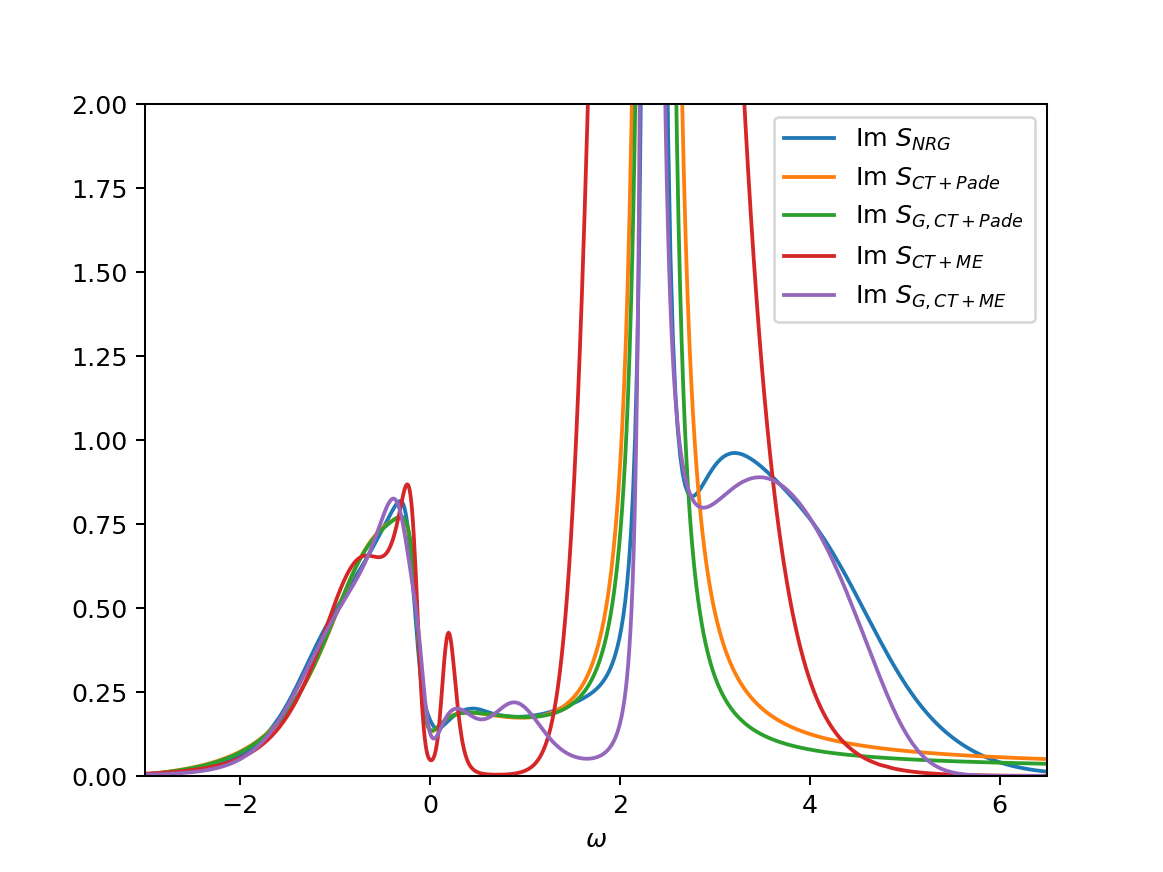

In [18]:
plt.figure(5)
plt.plot(S_nrg[:,0], -S_nrg[:,1], label='Im $S_{NRG}$')
oplot(-S_pade.imag)
oplot(-SG_pade.imag)
oplot(-SR.imag)
oplot(-SG.imag)
plt.ylabel('')
plt.xlim([-3,6.5])
plt.legend()
plt.figure(6)
plt.plot(S_nrg[:,0], -S_nrg[:,1], label='Im $S_{NRG}$')
oplot(-S_pade.imag)
oplot(-SG_pade.imag)
oplot(-SR.imag)
oplot(-SG.imag)
plt.ylabel('')
plt.xlim([-3,6.5])
plt.ylim([0,2])
plt.legend()

On figure (5), we can seen that the sharpest peak is now the MaxEnt result $S_{G,CT+ME}$ obtained with the artificial Green's function method. On figure (6), we see that $S_{G,CT+ME}$ also contains the secondary peak around $\omega=3.5$. Using the zoom tool, we can also see how $S_{G,CT+ME}$ is much closer to the NRG result than $S_{CT+ME}$ around $\omega=0$. The Padé result is also slightly improved using this way of continuing the self-energy.

In [19]:
os.chdir("..")
su.rmtree(output_dir)

## Exercise:

Perform the analytic continuation, using only the artificial Green's function method, for the data at $\beta=50$ in the file *CTHYB/Sigma_50.0_fittail.dat*.

[Here][solution] is the solution.

[solution]: https://github.com/TRIQS/omegamaxent_interface/blob/master/tutorials/DMFT_Continuous%20Time%20QMC%20%2B%20Analytic%20Continuation%20vs%20Numerical%20Renormalization_solution.ipynb